In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

import pickle

# Temporal chaotic realization of Mackey-Glass system

$\frac{dx}{dt} = \beta\frac{x_\tau}{1+x^n_\tau}-\gamma x$

$\beta=0.2$, $\gamma=0.1$, $\tau=17$, $n=10$

$x_\tau=x(t-\tau)$

Text(0, 0.5, 'x')

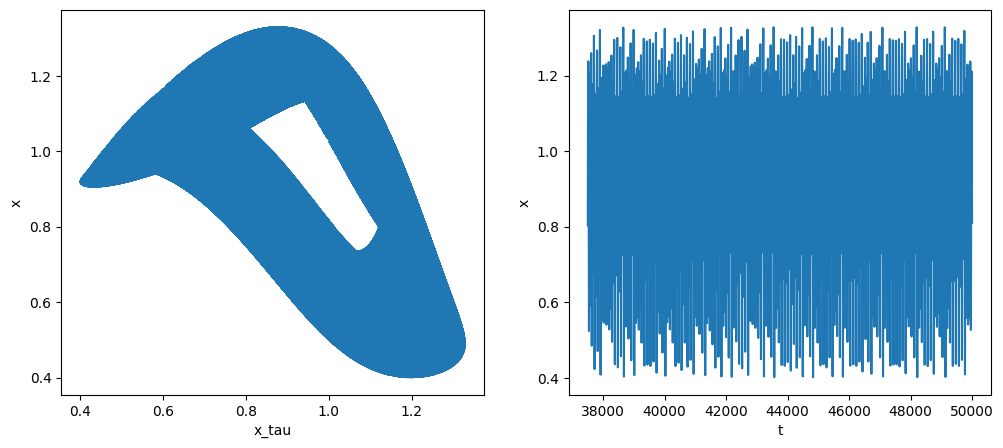

In [2]:
mg_beta = 0.2
mg_gamma = 0.1
mg_tau = 17
mg_n = 10
mg_h = 1
mg_T = 50000

mg_x0=0.3

mg_real = []

for t in np.arange(0,mg_tau,mg_h) :
    mg_real.append(mg_x0)

i=0
for t in np.arange(0,mg_T,mg_h) :
    x_tau = mg_real[i]
    x = mg_real[-1]
    x_new = x + mg_h*(mg_beta*x_tau/(1+x_tau**mg_n)-mg_gamma*x)
    mg_real.append(x_new)
    i += 1

t_values = []
x_values = []
x_tau_values = []
for t in np.arange(0,mg_T,mg_h) :
    x_tau = mg_real[i]
    x = mg_real[-1]
    x_new = x + mg_h*(mg_beta*x_tau/(1+x_tau**mg_n)-mg_gamma*x)
    x_values.append(x_new)
    mg_real.append(x_new)
    x_tau_values.append(x_tau)
    t_values.append(t)
    i += 1

mg_t_values = np.array(t_values).reshape(-1,1)
mg_x_values = np.array(x_values).reshape(-1,1)
mg_x_tau_values = np.array(x_tau_values).reshape(-1,1)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.set_xlabel("x_tau")
ax1.set_ylabel("x")
ax1.plot(mg_x_tau_values, mg_x_values)
ax2 = fig.add_subplot(122)
ax2.plot(t_values[int(len(mg_t_values)*3/4):], x_values[int(len(mg_t_values)*3/4):])
ax2.set_xlabel("t")
ax2.set_ylabel("x")


In [3]:
#data = np.array(sine_x_values).reshape(-1,1)
data = np.array(mg_x_values).reshape(-1,1)

num_examples = len(mg_x_values)
training_len = 20000
testing_len = 1000

x_train = data[:training_len]
y_train = data[1:training_len+1]
x_test  = data[training_len:training_len+testing_len]
y_test  = data[training_len+1:training_len+testing_len+1]

print(np.shape(x_train), np.shape(y_train), "|||", np.shape(x_test), np.shape(y_test))


(20000, 1) (20000, 1) ||| (1000, 1) (1000, 1)


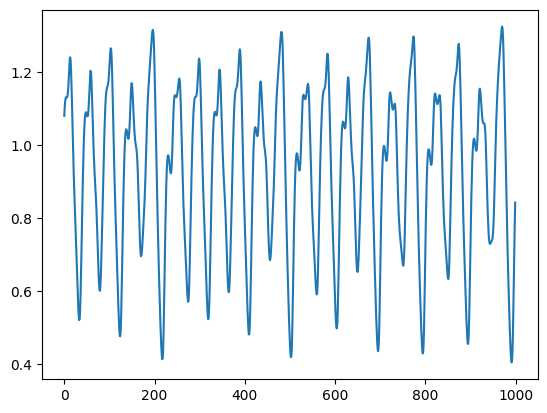

In [4]:
plt.plot(x_test)

# Main functions

## Activation functions

In [5]:
def func_relu (x) :
    y = x
    y[y<0]=0
    return y


In [6]:
def reservoir_activation_function (x) :
    #return 1/(1+np.exp(-x))
    return np.tanh(x)
    #return func_relu(x)
    

## Propagation through reservoir

In [7]:
def get_reservior_values(input_data, my_net, leaking_rate):
    # Initialize reservoir states
    reservoir_states = np.zeros((len(input_data), my_net['nres']))
    reservoir_states[0,:] =(1-leaking_rate)*my_net['res_last'] + leaking_rate*reservoir_activation_function( np.dot(input_data[0], my_net['Win']) + np.dot(my_net['res_last'], my_net['Wres']) )

    # Run the reservoir
    for t in range(1, len(input_data)) :
        reservoir_states[t,:] = (1-leaking_rate)*my_net['res_last'] + leaking_rate*reservoir_activation_function( np.dot(input_data[t], my_net['Win']) + np.dot(reservoir_states[t - 1, :], my_net['Wres']) )
    my_net['res_last'] = np.array(reservoir_states[len(input_data)-1,:])
    return reservoir_states, my_net

## Predictions without and with noise

In [8]:
def predict(input_data, my_net_old, leaking_rate):
    my_net = dict(my_net_old)
    # Get the signal after reservoir
    reservoir_states, my_net = get_reservior_values(input_data, my_net, leaking_rate)

    # Output of ESN
    #predicted_output = np.dot(np.hstack((np.ones((len(input_data),1)),reservoir_states)), my_net['Wout'])
    predicted_output = np.dot(reservoir_states, my_net['Wout'])
    return predicted_output, my_net

In [9]:
def predict_noise(input_data, my_net_old, leaking_rate, noise_intensities):
        
    my_net = dict(my_net_old)
    # Get the signal after reservoir
    reservoir_states, my_net = get_reservior_values(input_data, my_net, leaking_rate)
    reservoir_states = reservoir_states*(1+np.sqrt(2*noise_intensities['D_MU'])*np.random.normal(0,1,np.shape(reservoir_states))) + np.sqrt(2*noise_intensities['D_AU'])*np.random.normal(0,1,np.shape(reservoir_states))

    # Output of ESN
    #predicted_output = np.dot(np.hstack((np.ones((len(input_data),1)),reservoir_states)), my_net['Wout'])
    predicted_output = np.dot(reservoir_states, my_net['Wout'])
    return predicted_output, my_net

## Closed-loop ESN wihtout and with noise

In [10]:
def free_moving(initial_condition, iterations_num, my_net_old, leaking_rate):
    my_net = dict(my_net_old)
    input_new = np.array(initial_condition).reshape(1,1)
    predicted_output = []

    for i in range(iterations_num) :
      my_net['res_last'] = (1-leaking_rate)*my_net['res_last'] + leaking_rate*reservoir_activation_function( np.dot(input_new, my_net['Win']) + np.dot(my_net['res_last'], my_net['Wres']) )
      #output_new = np.dot(np.array(list([1])+list(my_net['res_last'].reshape(-1))).reshape(1,-1), my_net['Wout']).reshape(1,1)
      output_new = np.dot(my_net['res_last'], my_net['Wout']).reshape(1,1)

      predicted_output.append(float(output_new))
      input_new = np.array(output_new)

    return np.array(predicted_output).reshape(-1,1), my_net
    #return np.array(predicted_output[1:]).reshape(-1,1), my_net

In [11]:
def free_moving_noise(initial_condition, iterations_num, my_net_old, leaking_rate, noise_intensities):
    my_net = dict(my_net_old)
    input_new = np.array(initial_condition).reshape(1,1)
    predicted_output = []

    for i in range(iterations_num) :
      my_net['res_last'] = (1-leaking_rate)*my_net['res_last'] + leaking_rate*reservoir_activation_function( np.dot(input_new, my_net['Win']) + np.dot(my_net['res_last'], my_net['Wres']) )
      my_net['res_last'] = my_net['res_last']*(1+np.sqrt(2*noise_intensities['D_MU'])*np.random.normal(0,1,np.shape(my_net['res_last']))) + np.sqrt(2*noise_intensities['D_AU'])*np.random.normal(0,1,np.shape(my_net['res_last']))
      #output_new = np.dot(np.array(list([1])+list(my_net['res_last'].reshape(-1))).reshape(1,-1), my_net['Wout']).reshape(1,1)
      output_new = np.dot(my_net['res_last'], my_net['Wout']).reshape(1,1)

      predicted_output.append(float(output_new))
      input_new = np.array(output_new)

    return np.array(predicted_output).reshape(-1,1), my_net
    #return np.array(predicted_output[1:]).reshape(-1,1), my_net

## Creating the network

In [16]:
def func_initialize_network(n_inputs, n_reservoir, n_outputs, spectral_radius, reservoir_connectivity):

  W_res_rand = np.zeros((n_reservoir, n_reservoir))
  for j in range(n_reservoir) :
    k=0
    while (k<reservoir_connectivity*n_reservoir) :
      i = int(np.random.rand()*n_reservoir)
      if (W_res_rand[i,j]==0) :
        W_res_rand[i,j] = np.random.rand() - 0.5
        k += 1

  W_res_band = np.zeros((n_reservoir, n_reservoir))
  kk = int(n_reservoir*reservoir_connectivity/2)
  for j in range(n_reservoir) :
    W_line = list([0]*n_reservoir)
    for k in range(j-kk,j+kk+1,1) :
        if k<0 : i=k+n_reservoir
        elif k>=n_reservoir : i=k-n_reservoir
        else : i=k
        W_res_band[i,j] = np.random.rand() - 0.5

  W_res = np.array(W_res_rand)  
  #W_res = np.array(W_res_band)
  W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(W_res.T)))

  network = {#'Win'  : 2*(np.random.rand(n_inputs, n_reservoir) - 0.5),
             'Win'  : np.ones((n_inputs, n_reservoir)),
             'Wres' : W_res,
             'Wout' : (np.random.rand(n_reservoir+1, n_outputs)), #,np.zeros((n_reservoir, n_outputs)),
             'nres' : n_reservoir,
             'res_last' : np.zeros((1, n_reservoir))
            }

  return network

## Training
Finally, we get the matrix Wout using pseudo-inverse matrix and ridge regression

In [17]:
def train_echo(input_data, target_data, my_net_old, leaking_rate):
    my_net = dict(my_net_old)
    # Get reservoir values
    reservoir_states, my_net = get_reservior_values(input_data, my_net, leaking_rate)
    # Get new Wout
    #X = np.hstack((np.ones((len(input_data),1)),reservoir_states))
    X = np.array(reservoir_states)
    W_out = np.dot(np.dot(X,  np.linalg.inv( np.dot(X.T,X) + 0.0001*np.eye(np.size(X,1))) ).T, target_data)

    my_net['Wout'] = W_out

    return my_net

In [18]:
def train_echo_noise(input_data, target_data, my_net_old, leaking_rate, noise_intensities):
    my_net = dict(my_net_old)
    # Get reservoir values
    reservoir_states, my_net = get_reservior_values(input_data, my_net, leaking_rate)
    reservoir_states = reservoir_states*(1+np.sqrt(2*noise_intensities['D_MU'])*np.random.normal(0,1,np.shape(reservoir_states))) + np.sqrt(2*noise_intensities['D_AU'])*np.random.normal(0,1,np.shape(reservoir_states))
    
    # Get new Wout
    #X = np.hstack((np.ones((len(input_data),1)),reservoir_states))
    X = np.array(reservoir_states)
    W_out = np.dot(np.dot(X,  np.linalg.inv( np.dot(X.T,X) + 0.0001*np.eye(np.size(X,1))) ).T, target_data)

    my_net['Wout'] = W_out

    return my_net

# Network parameters

In [19]:
size_input = 1
size_reservoir = 1000
size_output = 1

spectral_radius = 1.2
reservoir_connectivity = 0.01
leaking_rate = 1

# Training the network

In [20]:
my_net = func_initialize_network(size_input, size_reservoir, size_output, spectral_radius, reservoir_connectivity)
my_net['res_last'] = np.zeros((1, size_reservoir))
my_net_init = dict(my_net)

my_net = train_echo(x_train, y_train, my_net, leaking_rate)

my_net['res_last'] = np.zeros((1, size_reservoir))
y_train_predicted, my_net = predict(x_train, my_net, leaking_rate)
my_net_after_trainig = dict(my_net)

# Testing

### Open-loop ESN

(1000, 1) (1000, 1)
(1000, 1)
Testing MSE = 3.216383981916311e-08


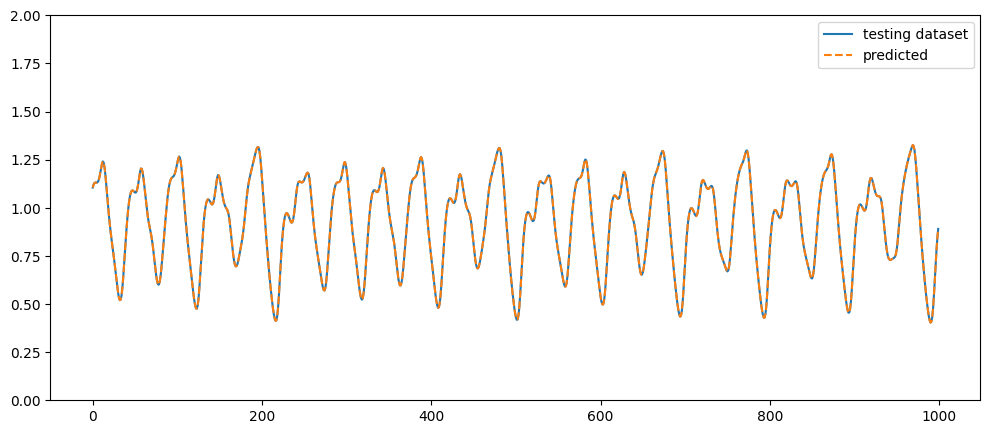

In [21]:
my_net = dict(my_net_after_trainig)
y_test_predicted, my_net = predict(x_test, my_net, leaking_rate)
print(np.shape(x_test), np.shape(y_test))

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="predicted")
ax.set_ylim([0,2])
ax.legend()
print(np.shape(y_test))
print("Testing MSE =",np.mean((y_test-y_test_predicted)**2))

### Closed-loop ESN

1.0803864697406138
Free moving  MSE = 0.07069251486535391


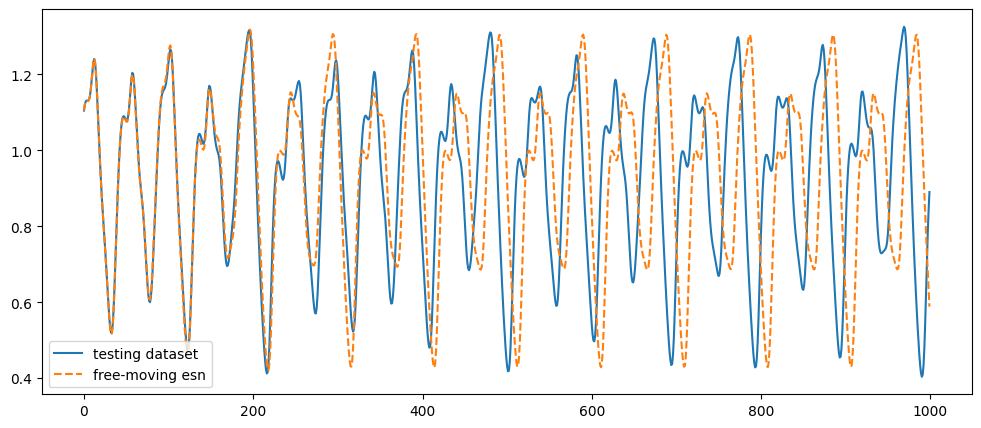

In [22]:
my_net = dict(my_net_after_trainig)
print(x_test[0,0])
y_test_predicted, my_net = free_moving(x_test[0,0], len(x_test), my_net, leaking_rate)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="free-moving esn")
#ax.set_ylim([-5,5])
ax.legend()
print("Free moving  MSE =",np.mean((y_test-y_test_predicted)**2))

### Save trained net

In [23]:
import pickle

with open('examples/net00/last_esn.pkl', 'wb') as f:
    pickle.dump(my_net_after_trainig, f)

with open('examples/net00/last_esn_init.pkl', 'wb') as f:
    pickle.dump(my_net_init, f)

______

# Load trained ESN

In [24]:
folder_to_load = "examples/net00"

with open(folder_to_load+'/last_esn.pkl', 'rb') as f:
    my_net_after_trainig = pickle.load(f)

Training MSE = 3.1500327875387824e-08


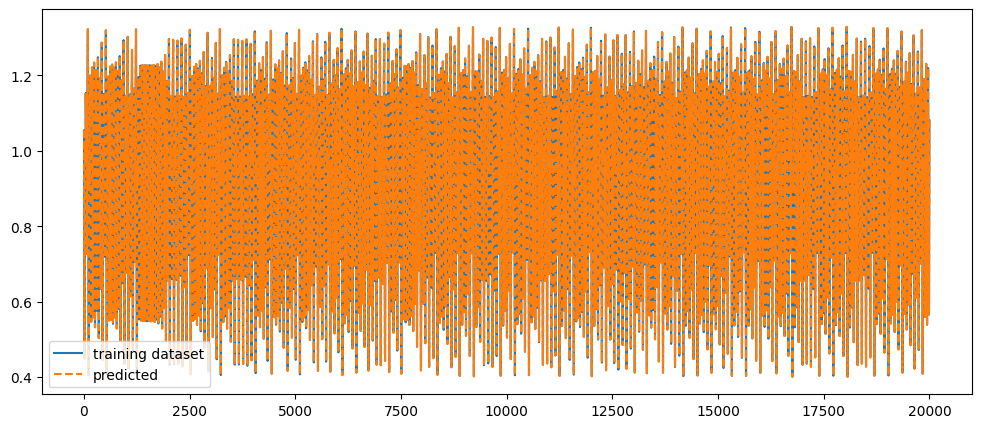

In [25]:
my_net = dict(my_net_after_trainig)

my_net['res_last'] = np.zeros((1, size_reservoir))
y_train_predicted, my_net = predict(x_train, my_net, leaking_rate)
#my_net_after_trainig = dict(my_net)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_train,label="training dataset")
ax.plot(y_train_predicted,'--', label="predicted")
ax.legend()
print("Training MSE =",np.mean((y_train-y_train_predicted)**2))

### Open-loop ESN

(1000, 1) (1000, 1)
(1000, 1)
Testing MSE = 3.216383981916311e-08


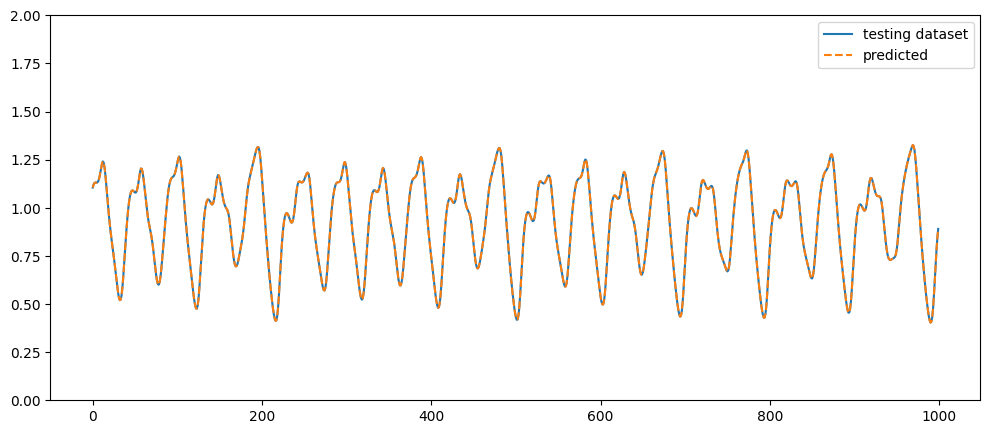

In [26]:
my_net = dict(my_net_after_trainig)
y_test_predicted, my_net = predict(x_test, my_net, leaking_rate)
print(np.shape(x_test), np.shape(y_test))

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="predicted")
ax.set_ylim([0,2])
ax.legend()
print(np.shape(y_test))
print("Testing MSE =",np.mean((y_test-y_test_predicted)**2))

### Closed-loop ESN

1.0803864697406138
Free moving  MSE = 0.07069251486535391


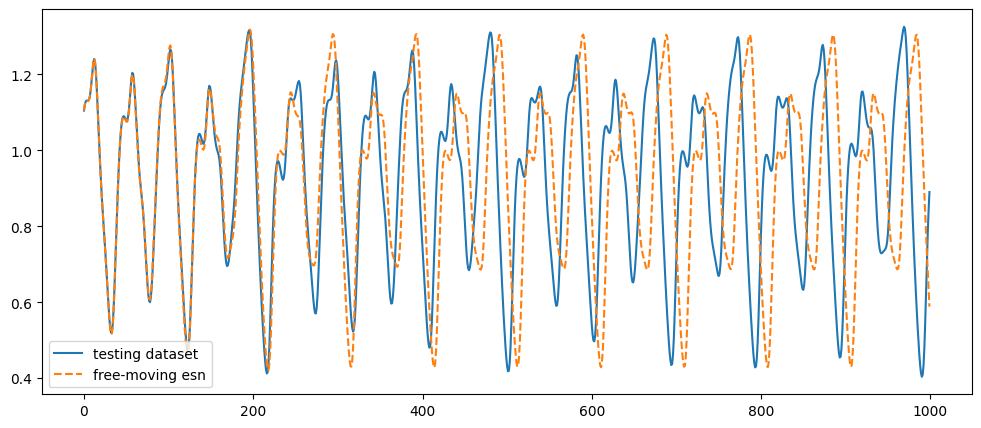

In [27]:
my_net = dict(my_net_after_trainig)
print(x_test[0,0])
y_test_predicted, my_net = free_moving(x_test[0,0], len(x_test), my_net, leaking_rate)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="free-moving esn")
#ax.set_ylim([-5,5])
ax.legend()
print("Free moving  MSE =",np.mean((y_test-y_test_predicted)**2))


# Now with noise

In [58]:
noise_intensities = {'D_AU'  : 0,
             'D_MU' : 0.00001
            }

(1000, 1) (1000, 1)
(1000, 1)
Testing MSE = 2.5182634493477756e-06


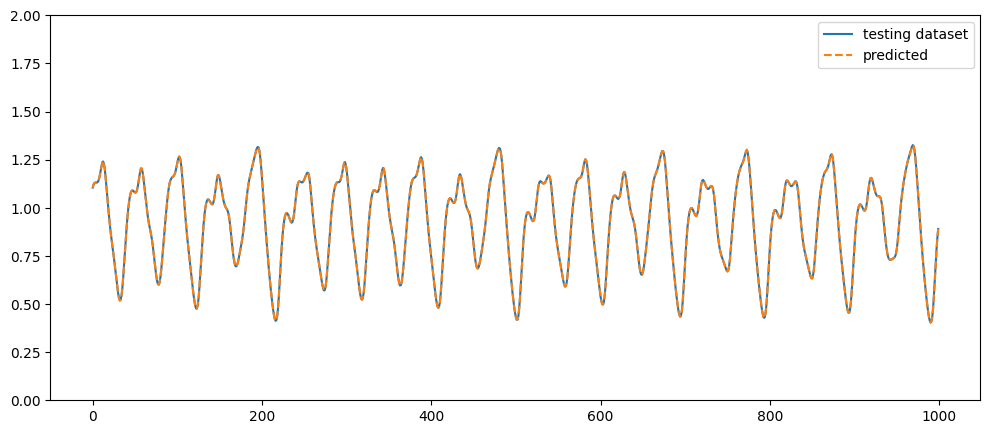

In [59]:
my_net = dict(my_net_after_trainig)
y_test_predicted, my_net = predict_noise(x_test, my_net, leaking_rate, noise_intensities)
print(np.shape(x_test), np.shape(y_test))

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="predicted")
ax.set_ylim([0,2])
ax.legend()
print(np.shape(y_test))
print("Testing MSE =",np.mean((y_test-y_test_predicted)**2))

In [60]:
K=100
MSE_vals = []
RMSE_vals = []
NMSE_vals = []
for k in range(K) :
    if k%10 == 0 :
        print(k,'/',K)
    my_net = dict(my_net_after_trainig)
    y_test_predicted, my_net = predict_noise(x_test, my_net, leaking_rate, noise_intensities)
    MSE_vals.append(np.mean((y_test-y_test_predicted)**2))
    RMSE_vals.append(np.sqrt(np.mean((y_test-y_test_predicted)**2)))
    NMSE_vals.append(np.mean((y_test-y_test_predicted)**2)/np.mean(y_test**2))

print(k+1,'/',K)
    
np.savetxt(folder_to_load+"/MSE_trained_D=0_testing_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(MSE_vals))
np.savetxt(folder_to_load+"/RMSE_trained_D=0_testing_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(RMSE_vals))
np.savetxt(folder_to_load+"/NMSE_trained_D=0_testing_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(NMSE_vals))

print("Free moving MSE mean=", np.mean(MSE_vals), "   max=",max(MSE_vals), "   min=",min(MSE_vals))
print("Free moving RMSE mean=", np.mean(RMSE_vals), "   max=",max(RMSE_vals), "   min=",min(RMSE_vals))
print("Free moving NMSE mean=", np.mean(NMSE_vals), "   max=",max(NMSE_vals), "   min=",min(NMSE_vals))

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100
Free moving MSE mean= 2.5093035575849355e-06    max= 2.79248720799303e-06    min= 2.3095807945327836e-06
Free moving RMSE mean= 0.0015837307631046524    max= 0.001671073669229765    min= 0.0015197305006259443
Free moving NMSE mean= 2.7417813502374594e-06    max= 3.05120092963994e-06    min= 2.523555004007227e-06


1.0803864697406138
Free moving  MSE = 1.600270593734266


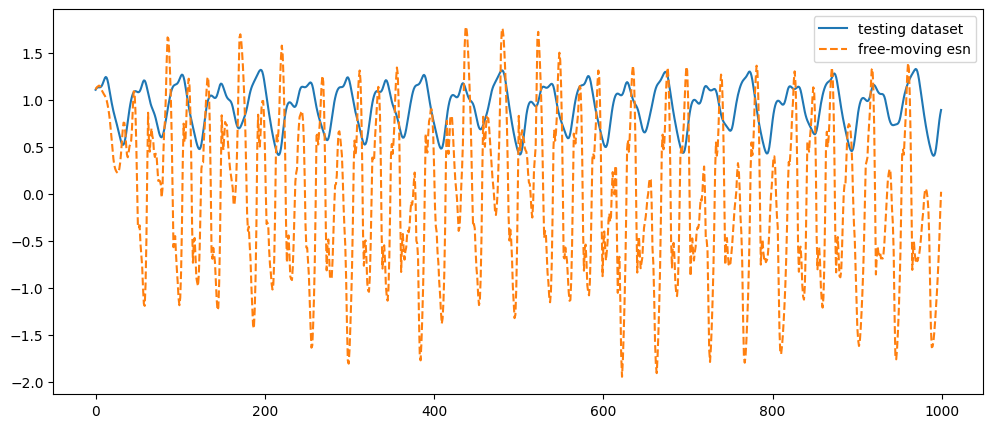

In [61]:
my_net = dict(my_net_after_trainig)
print(x_test[0,0])
y_test_predicted, my_net = free_moving_noise(x_test[0,0], len(x_test), my_net, leaking_rate, noise_intensities)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="free-moving esn")
#ax.set_ylim([-5,5])
ax.legend()
print("Free moving  MSE =",np.mean((y_test-y_test_predicted)**2))

In [62]:
K=100
MSE_vals = []
RMSE_vals = []
NMSE_vals = []
for k in range(K) :
    if k%10 == 0 :
        print(k,'/',K)
    my_net = dict(my_net_after_trainig)
    y_test_predicted, my_net = free_moving_noise(x_test[0,0], len(x_test), my_net, leaking_rate, noise_intensities)

    MSE_vals.append(np.mean((y_test-y_test_predicted)**2))
    RMSE_vals.append(np.sqrt(np.mean((y_test-y_test_predicted)**2)))
    NMSE_vals.append(np.mean((y_test-y_test_predicted)**2)/np.mean(y_test**2))

print(k+1,'/',K)

np.savetxt(folder_to_load+"/MSE_trained_D=0_free_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(MSE_vals))
np.savetxt(folder_to_load+"/RMSE_trained_D=0_free_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(RMSE_vals))
np.savetxt(folder_to_load+"/NMSE_trained_D=0_free_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(NMSE_vals))
    
print("Free moving MSE mean=", np.mean(MSE_vals), "   max=",max(MSE_vals), "   min=",min(MSE_vals))

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100
Free moving MSE mean= 1.4675365201413675    max= 1.784219716903922    min= 0.9192907106524387


# Training with noise

In [63]:
with open(folder_to_load+'/last_esn_init.pkl', 'rb') as f:
    my_net_start = pickle.load(f)

In [64]:
my_net = dict(my_net_start)
my_net['res_last'] = np.zeros((1, size_reservoir))
my_net_init = dict(my_net)

my_net = train_echo_noise(x_train, y_train, my_net, leaking_rate, noise_intensities)

my_net['res_last'] = np.zeros((1, size_reservoir))
y_train_predicted, my_net = predict_noise(x_train, my_net, leaking_rate, noise_intensities)
my_net_after_trainig = dict(my_net)

### Open-loop ESN

(1000, 1) (1000, 1)
(1000, 1)
Testing MSE = 2.5137745375262525e-06


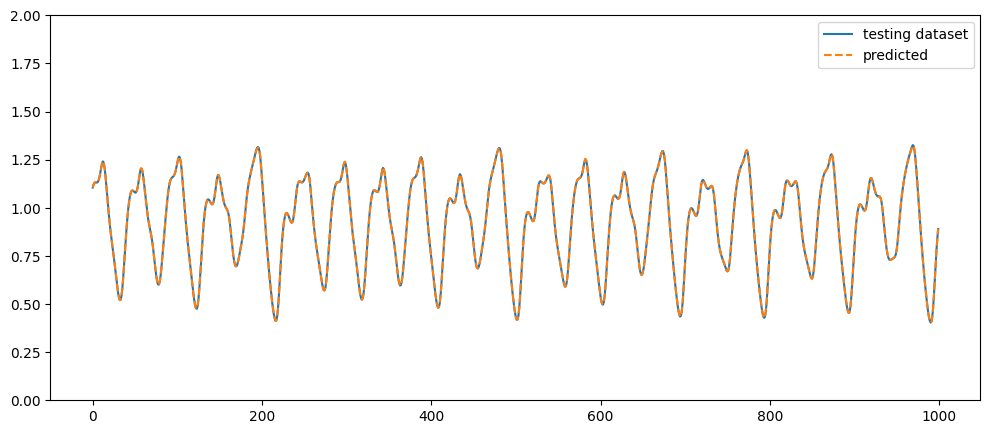

In [65]:
my_net = dict(my_net_after_trainig)
y_test_predicted, my_net = predict_noise(x_test, my_net, leaking_rate, noise_intensities)
print(np.shape(x_test), np.shape(y_test))

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="predicted")
ax.set_ylim([0,2])
ax.legend()
print(np.shape(y_test))
print("Testing MSE =",np.mean((y_test-y_test_predicted)**2))

### Closed-loop ESN

1.0803864697406138
Free moving  MSE = 1.299219888690454


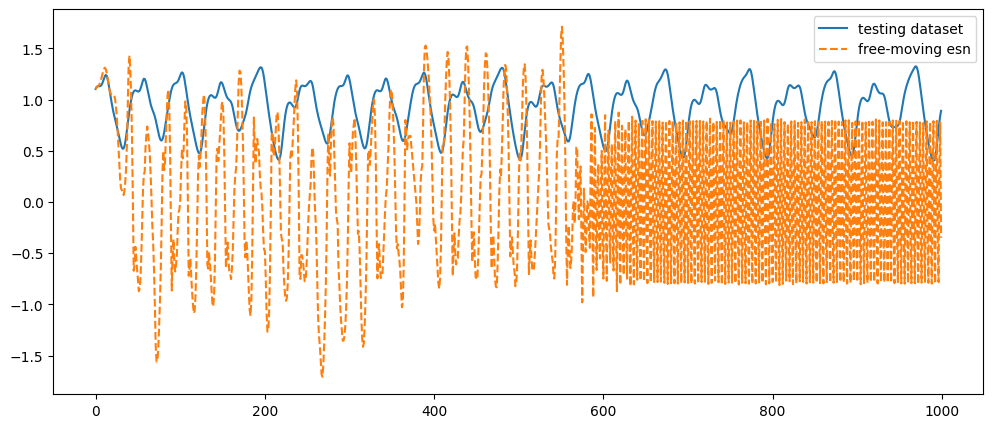

In [66]:
my_net = dict(my_net_after_trainig)
print(x_test[0,0])
y_test_predicted, my_net = free_moving_noise(x_test[0,0], len(x_test), my_net, leaking_rate, noise_intensities)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(y_test,label="testing dataset")
ax.plot(y_test_predicted,'--', label="free-moving esn")
#ax.set_ylim([-5,5])
ax.legend()
print("Free moving  MSE =",np.mean((y_test-y_test_predicted)**2))

In [67]:
K=100
MSE_vals_training = []
MSE_vals_testing = []
MSE_vals_free = []

RMSE_vals_training = []
RMSE_vals_testing = []
RMSE_vals_free = []

NMSE_vals_training = []
NMSE_vals_testing = []
NMSE_vals_free = []

for k in range(K) :
    if k%10 == 0 :
        print(k,'/',K)
        
    my_net = dict(my_net_start)
    my_net['res_last'] = np.zeros((1, size_reservoir))
    my_net = train_echo_noise(x_train, y_train, my_net, leaking_rate, noise_intensities)

    my_net_after_trainig = dict(my_net)
    
    my_net = dict(my_net_after_trainig)
    my_net['res_last'] = np.zeros((1, size_reservoir))
    y_train_predicted, my_net = predict_noise(x_train, my_net, leaking_rate, noise_intensities)
    MSE_vals_training.append(np.mean((y_train-y_train_predicted)**2))
    RMSE_vals_training.append(np.sqrt(np.mean((y_train-y_train_predicted)**2)))
    NMSE_vals_training.append(np.mean((y_train-y_train_predicted)**2)/np.mean(y_train**2))

    my_net = dict(my_net_after_trainig)
    y_test_predicted, my_net = predict_noise(x_test, my_net, leaking_rate, noise_intensities)
    MSE_vals_testing.append(np.mean((y_test-y_test_predicted)**2))
    RMSE_vals_testing.append(np.sqrt(np.mean((y_test-y_test_predicted)**2)))
    NMSE_vals_testing.append(np.mean((y_test-y_test_predicted)**2)/np.mean(y_test**2))
    
    my_net = dict(my_net_after_trainig)
    y_test_predicted, my_net = free_moving_noise(x_test[0,0], len(x_test), my_net, leaking_rate, noise_intensities)
    MSE_vals_free.append(np.mean((y_test-y_test_predicted)**2))
    RMSE_vals_free.append(np.sqrt(np.mean((y_test-y_test_predicted)**2)))
    NMSE_vals_free.append(np.mean((y_test-y_test_predicted)**2)/np.mean(y_test**2))
print(k+1,'/',K)

np.savetxt(folder_to_load+"/MSE_training_training_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(MSE_vals_training))
np.savetxt(folder_to_load+"/RMSE_training_training_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(RMSE_vals_training))
np.savetxt(folder_to_load+"/NMSE_training_training_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(NMSE_vals_training))

np.savetxt(folder_to_load+"/MSE_training_testing_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(MSE_vals_testing))
np.savetxt(folder_to_load+"/RMSE_training_testing_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(RMSE_vals_testing))
np.savetxt(folder_to_load+"/NMSE_training_testing_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(NMSE_vals_testing))
    
np.savetxt(folder_to_load+"/MSE_training_free_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(MSE_vals_free))
np.savetxt(folder_to_load+"/RMSE_training_free_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(RMSE_vals_free))
np.savetxt(folder_to_load+"/NMSE_training_free_Dau="+str(noise_intensities['D_AU'])+"_Dmu="+str(noise_intensities['D_MU'])+"_"+str(testing_len)+".dat", np.array(NMSE_vals_free))
    
print("Training MSE mean=", np.mean(MSE_vals_training), "   max=",max(MSE_vals_training), "   min=",min(MSE_vals_training))
print("Testing MSE mean=", np.mean(MSE_vals_testing), "   max=",max(MSE_vals_testing), "   min=",min(MSE_vals_testing))
print("Free MSE mean=", np.mean(MSE_vals_free), "   max=",max(MSE_vals_free), "   min=",min(MSE_vals_free))

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100
Training MSE mean= 2.527547227670092e-06    max= 2.5826282094723265e-06    min= 2.473955991156647e-06
Testing MSE mean= 2.496305477907256e-06    max= 2.7196553000365974e-06    min= 2.1623239745844218e-06
Free MSE mean= 1.3995428102496583    max= 1.7227348130359659    min= 0.9804819846303726
